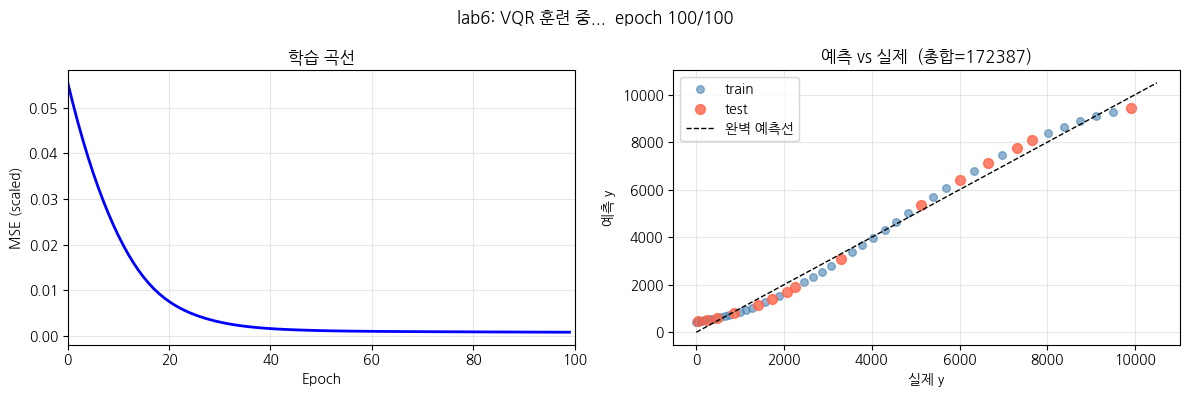

  VQR 총합:  172386.9  (이론: 169150)
  test MSE:  122573.83
  파라미터:  6개

lab6 완료!


In [1]:
# !pip install pennylane koreanize_matplotlib -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from IPython.display import clear_output
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
n_layers = 3      # Ansatz 레이어 수: 1 / 2 / 3
epochs   = 100
lr       = 0.01   # 학습률: 0.001 / 0.01 / 0.1
# ===== 수정 끝 =====
# ============================================================

# --- Lab 5와 동일한 데이터 ---
x1 = std_np.array([2*i + 1   for i in range(50)], dtype=float)
x2 = std_np.array([2*(i + 1) for i in range(50)], dtype=float)
y  = x1 * x2
THEORY_SUM = 169150

def scale_x(x):
    return (x - 1) / 99 * std_np.pi

Y_MIN, Y_MAX = 2.0, 9900.0

def scale_y(y_val):
    return (y_val - Y_MIN) / (Y_MAX - Y_MIN)

def unscale_y(y_scaled):
    return y_scaled * (Y_MAX - Y_MIN) + Y_MIN

x1_sc = scale_x(x1)
x2_sc = scale_x(x2)
y_sc  = scale_y(y)

std_np.random.seed(42)
idx       = std_np.random.permutation(50)
n_train   = 35
idx_train = idx[:n_train]
idx_test  = idx[n_train:]
print(f"  train: {n_train}개, test: {len(idx_test)}개 (셔플)")

# ===========================================================
#  lab6: VQR 변분 양자 회귀
# ===========================================================

print("\n" + "=" * 60)
print("lab6: VQR (변분 양자 회귀)")
print("=" * 60)

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def vqr_circuit(inputs, weights):
    # 인코딩
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.CNOT(wires=[0, 1])
    # Ansatz
    for l in range(n_layers):
        qml.RY(weights[l, 0], wires=0)
        qml.RY(weights[l, 1], wires=1)
        qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

n_params = n_layers * 2
print(f"  회로 구조: RY+CNOT 인코딩 + RY+CNOT Ansatz x {n_layers}")
print(f"  파라미터 수: {n_params}  (n_layers={n_layers} x 2)")

# 회로도 시각화
w_init      = np.array(std_np.random.uniform(0, std_np.pi, (n_layers, 2)),
                        requires_grad=True)
sample_inp  = np.array([x1_sc[0], x2_sc[0]])
fig, _      = qml.draw_mpl(vqr_circuit, decimals=2)(sample_inp, w_init)
fig.suptitle(f"lab6: VQR 회로도 (n_layers={n_layers})", fontsize=12)
plt.show()

# 비용 함수
def vqr_cost(weights):
    total = np.array(0.0)
    for i in idx_train:
        inp  = np.array([x1_sc[i], x2_sc[i]])
        pred = (vqr_circuit(inp, weights) + 1) / 2   # [-1,1] -> [0,1]
        total = total + (pred - y_sc[i]) ** 2
    return total / n_train

# 예측 함수
def vqr_predict(weights):
    preds = []
    for i in range(50):
        inp   = np.array([x1_sc[i], x2_sc[i]])
        p_sc  = (float(vqr_circuit(inp, weights)) + 1) / 2
        preds.append(unscale_y(p_sc))
    return std_np.array(preds)

# 학습 (실시간 시각화)
opt          = qml.AdamOptimizer(stepsize=lr)
weights      = w_init.copy()
vqr_history  = []

for ep in range(epochs):
    weights = opt.step(vqr_cost, weights)
    loss    = float(vqr_cost(weights))
    vqr_history.append(loss)

    if ep % 10 == 0 or ep == epochs - 1:
        clear_output(wait=True)
        preds_now  = vqr_predict(weights)
        sum_now    = preds_now.sum()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"lab6: VQR 훈련 중...  epoch {ep+1}/{epochs}", fontsize=12)

        # 왼쪽: 학습 곡선
        ax1.plot(vqr_history, 'b-', lw=2)
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("MSE (scaled)")
        ax1.set_title("학습 곡선")
        ax1.set_xlim(0, epochs)
        ax1.grid(True, alpha=0.3)

        # 오른쪽: 예측 vs 실제
        ax2.scatter(y[idx_train], preds_now[idx_train],
                    c='steelblue', alpha=0.6, s=30, label='train')
        ax2.scatter(y[idx_test],  preds_now[idx_test],
                    c='tomato',    alpha=0.8, s=50, label='test')
        ax2.plot([0, 10500], [0, 10500], 'k--', lw=1, label='완벽 예측선')
        ax2.set_xlabel("실제 y"); ax2.set_ylabel("예측 y")
        ax2.set_title(f"예측 vs 실제  (총합={sum_now:.0f})")
        ax2.legend(); ax2.grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()

# 최종 결과
vqr_preds    = vqr_predict(weights)
vqr_sum      = vqr_preds.sum()
vqr_test_mse = std_np.mean((vqr_preds[idx_test] - y[idx_test]) ** 2)

print(f"  VQR 총합:  {vqr_sum:.1f}  (이론: {THEORY_SUM})")
print(f"  test MSE:  {vqr_test_mse:.2f}")
print(f"  파라미터:  {n_params}개")

print("\nlab6 완료!")

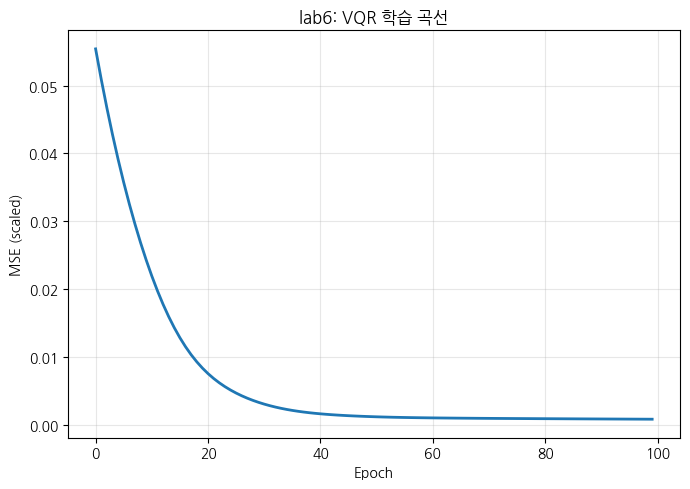

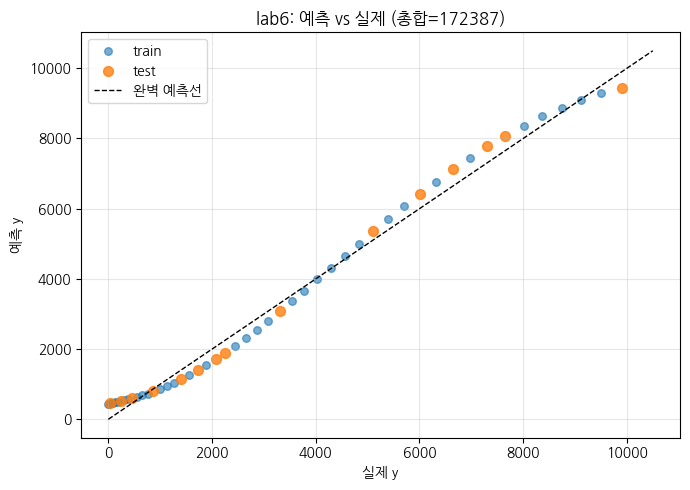

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(vqr_history, lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (scaled)")
ax.set_title("lab6: VQR 학습 곡선")
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("./fig/lab6a.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(y[idx_train], vqr_preds[idx_train],
           alpha=0.6, s=30, label='train')
ax.scatter(y[idx_test], vqr_preds[idx_test],
           alpha=0.8, s=50, label='test')

ax.plot([0, 10500], [0, 10500], 'k--', lw=1, label='완벽 예측선')

ax.set_xlabel("실제 y")
ax.set_ylabel("예측 y")
ax.set_title(f"lab6: 예측 vs 실제 (총합={vqr_sum:.0f})")

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("./fig/lab6b.png", dpi=300, bbox_inches="tight")
plt.show()
